In [6]:
import os, jax, torch, torchvision
from jax import numpy as jnp
from torch.utils.data import Dataset, DataLoader, default_collate
from matplotlib import pyplot as plt

In [5]:
class Imagenet(Dataset):
    # def __init__(self, data_path="./data/Data/CLS-LOC/train"):
        # g = os.walk(data_path, topdown=True)
        # self.classes = next(g)[1]
        # self.paths = [os.path.join(dirname, f) for (dirname, _, filenames) in g for f in filenames]

    def __len__(self):
        return 100_000#len(self.paths)

    def __getitem__(self, idx):
        s = torch.randint(128, 256, (2,))
        return torch.rand((3,*s)), torch.ones(1000).float()
        fp = self.paths[idx]
        img = torchvision.io.read_image(fp).float()
        if img.shape[1]<128 or img.shape[2]<128 or img.shape[0]!=3:
            del self.paths[idx]
            os.remove(fp)
            return self.__getitem__(idx)
        label = self.classes.index(fp.split("/")[-2].rstrip(".JPEG"))
        label = torch.eye(1000)[label].float()
        return img, label

def jax_collate(batch, n, key, feature_beta, label_beta, sample_overlap):
    imgs, labels = zip(*batch)
    # Find minimum height and width in this batch
    min_height = min(img.shape[1] for img in imgs)
    min_width = min(img.shape[2] for img in imgs)
    # Resize images to the minimum height and width
    imgs = [torchvision.transforms.functional.resize(img, (min_height, min_width)) for img in imgs]
    # Convert and concat
    imgs = jnp.swapaxes(jnp.stack([jnp.asarray(img) for img in imgs]), 1, -1)
    labels = jnp.stack([jnp.asarray(label) for label in labels])
    
    # Create feature skew augmentations 
    # TODO: check that these four distributions are equally different from each other?
    imgs_rot = jnp.rot90(imgs, k=2, axes=(1,2))
    imgs_inv = 1-imgs
    imgs_inv_rot = jnp.rot90(1-imgs, k=2, axes=(1,2))
    all_augs = jnp.stack([imgs, imgs_rot, imgs_inv, imgs_inv_rot], axis=0)
    # Create n heterogeneous skews by randomly summing the four augmentations, while equally representing them globally
    proportions = jax.vmap(jnp.roll, in_axes=(0,0,None))(jnp.tile(jnp.linspace(0,1,n), (4, 1)), jnp.arange(4), None).T
    proportions = proportions[...,None,None,None,None]
    clients_imgs = all_augs*proportions
    clients_imgs = clients_imgs.sum(axis=1)
    # Scale to [0,1] because we lost that guarantee
    clients_imgs = (clients_imgs - clients_imgs.min(axis=0)) / (clients_imgs.max(axis=0) - clients_imgs.min(axis=0))
    # Share samples between the fully heterogeneous clients according to the provided beta
    mix_frac = int(feature_beta*clients_imgs.shape[1])
    mix_idx = jax.random.choice(key, jnp.arange(clients_imgs.shape[1]), (mix_frac,), replace=False)
    mix_idx_inv = jnp.isin(jnp.arange(clients_imgs.shape[1]), mix_idx, invert=True)
    mix_samples = jnp.tile(clients_imgs[:, mix_idx].reshape(-1, *clients_imgs.shape[2:]), (n,1,1,1,1))
    clients_imgs = jnp.concat([mix_samples, clients_imgs[:, mix_idx_inv]], axis=1)
    # Broadcast labels
    labels = jnp.tile(labels, (n,1,1))
    mix_labels = jnp.tile(labels[:,mix_idx], (1,n,1))
    labels = jnp.concat([mix_labels, labels[:,mix_idx_inv]], axis=1)
    return clients_imgs, labels

In [18]:
ds = DataLoader(Imagenet(), batch_size=20, collate_fn=lambda b: jax_collate(b, n=8, key=jax.random.PRNGKey(0), feature_beta=0., label_beta=0., sample_overlap=1.))

In [19]:
for x, y in ds:
    break

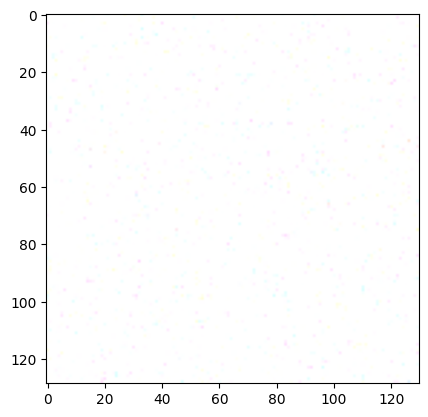

In [29]:
plt.imshow(x[7,2])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.42303577..1.0000001].


mix_idx [19 26 15 21 20  2  7 37 13 25 28  4 29 39 32 34]


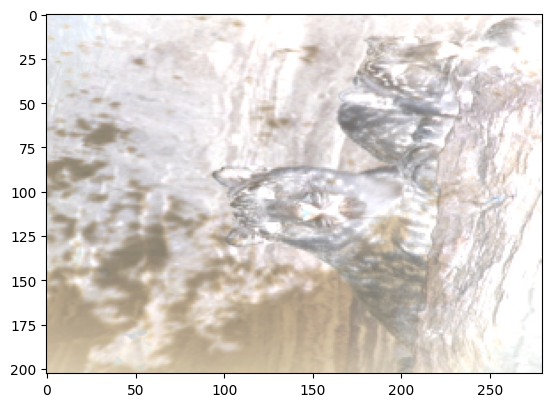

In [61]:
%load_ext autoreload
%autoreload 2
from data import create_imagenet
from matplotlib import pyplot as plt
import jax
import data
ds = create_imagenet(key=jax.random.PRNGKey(24385), n=8, feature_beta=0.4)
for x, y in ds:
    break
plt.imshow(x[2,5])

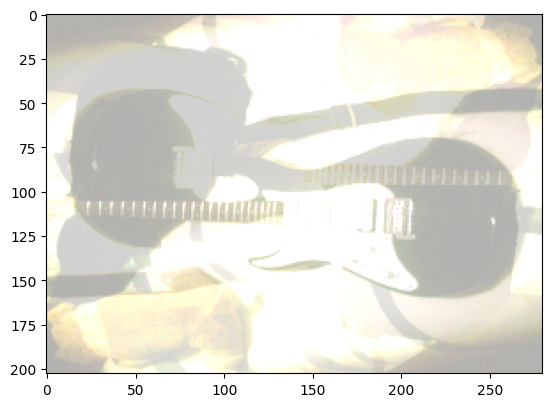

In [65]:
plt.imshow(data.clients_imgs[-1,5])

In [51]:
from data import class_name
class_name(ds, y[2,5])

'snow leopard, ounce, Panthera uncia'